In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
import pandas as pd

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F, F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states, dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 # hardcoded for 1d time_series

    F = np.zeros((dim_states, dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0, :len(phis)] = phis
    F[1:, :-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

In [3]:
def arma_forecast_naive(df, p=2, q=1, n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    # Load data
    obs = np.diff(df)
    z = np.zeros(n)
    z = np.concatenate((obs, z))
    epsilon = np.random.normal(0, .00005, len(z) + q)
    # Goes through our new observations
    for i in range(len(obs), len(z)):
        phi = .5 * np.ones(p)
        theta = .1 * np.ones(q)
        c = 0
        ar = 0
        ma = 0
        # solves ar
        for j in range(p):
            ar += phi[j]*z[i-j]
        # solves ma
        for j in range(q):
            ma += theta[j]*epsilon[i-j]
        z[i] = c + ar + ma + epsilon[i]
    t = np.arange(len(z))
    return z

In [4]:
def changes_to_data(x0, delx):
    x = [x0]
    for i in range(len(delx)):
        x.append(x[-1] + delx[i])
    return np.array(x)

In [5]:
# loads our data
avg = np.load('avgs.npy')
max = np.load('maxs.npy')
min = np.load('mins.npy')

In [6]:
# While testing I noticed some inconsistencies with max values this shows those concerned values
total = 0
for i in range(len(avg)):
    if(avg[i] < min[i]):
        print('Average less then min at', i)
        total += 1
    if(avg[i] > max[i]):
        print('Average greater then max at', i)
        total += 1
print(total)

Average less then min at 1706
Average less then min at 1709
Average greater then max at 2772
Average greater then max at 2783
Average greater then max at 2875
Average greater then max at 2876
Average greater then max at 2877
Average greater then max at 2878
Average greater then max at 2879
Average greater then max at 2880
Average greater then max at 2881
Average greater then max at 2882
Average less then min at 2888
Average less then min at 2889
Average less then min at 2890
Average less then min at 2891
Average less then min at 2892
Average less then min at 2893
Average less then min at 2894
Average less then min at 2895
Average greater then max at 2978
Average greater then max at 2979
Average greater then max at 2981
Average greater then max at 2982
Average less then min at 4084
Average less then min at 4085
Average less then min at 4086
Average less then min at 4088
Average less then min at 4089
Average less then min at 4090
Average greater then max at 4218
Average greater then max 

In [7]:
# Sets the max values as proper
for i in range(len(avg)):
    if(avg[i] < min[i]):
        min[i] = avg[i]
    if(avg[i] > max[i]):
        max[i] = avg[i]

In [8]:
# While testing I noticed some inconsistencies with max values this shows those concerned values
total = 0
for i in range(len(avg)):
    if(avg[i] < min[i]):
        print('Average less then min at', i)
        total += 1
    if(avg[i] > max[i]):
        print('Average greater then max at', i)
        total += 1
print(total)

0


In [9]:
# Starting off with 2 days of training
two_days_ago = avg[-2880:-50]
yesterday_actual = avg[-51:]

In [10]:
# Creates the naive forcast
z = arma_forecast_naive(two_days_ago, p=2, q=1, n=50)
act = np.diff(yesterday_actual)

In [11]:
t = np.arange(50)
two_days_ago = avg[:-50]
z = arma_forecast_naive(two_days_ago, p=2, q=1, n=50)
z_data = changes_to_data(avg[-51], z[-50:])[1:]

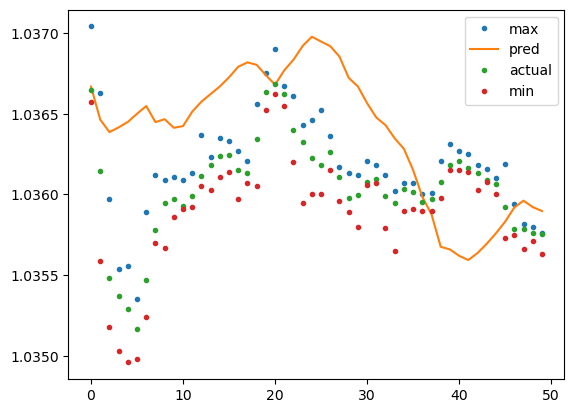

In [12]:
plt.plot(t, max[-50:],'.', label = 'max')
plt.plot(t, z_data[-50:], label = 'pred')
plt.plot(t, avg[-50:], '.', label = 'actual')
plt.plot(t, min[-50:],'.', label = 'min')
plt.legend()

In [13]:
def sm_arma(df, p_max=5, q_max=5, n=50):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # Loads data
    z = np.diff(df)
    best_model = None
    best_aic = np.inf
    best_p = 0
    best_q = 0
    # Loops through our p and q
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            print('p = ', p, ' q = ', q)
            model = ARIMA(z, order=(p, 0, q), trend='c').fit(method="innovations_mle")
            if best_aic > model.aic:
                best_aic = model.aic
                best_model = model
    # Plots our best model
    new_data = best_model.predict(start=0, end=len(z)+n)
    # plt.plot(z, label = "Old Data")
    # plt.plot(new_data, label = "ARMA Model")
    # plt.xlabel('Day')
    # plt.ylabel('Temperature Change')
    # plt.title('Prob5')
    # plt.legend()
    # plt.show()
            
            
    return new_data

In [ ]:
t = np.arange(50)
two_days_ago = avg[:-50]
z = sm_arma(two_days_ago, p_max=4, q_max=4, n=50)
z_data = changes_to_data(avg[-51], z[-50:])[1:]

p =  1  q =  1


In [ ]:
plt.plot(t, max[-50:],'.', label = 'max')
plt.plot(t, z_data[-50:], label = 'pred')
plt.plot(t, avg[-50:], '.', label = 'actual')
plt.plot(t, min[-50:],'.', label = 'min')
plt.legend()

In [ ]:
# t = np.arange(50)
# plt.plot(t, max[-50:], label = 'max')
# plt.plot(t, z_data, label = 'pred')
# plt.plot(t, avg[-50:], label = 'actual')
# plt.plot(t, min[-50:], label = 'min')
# plt.legend()